# Benchmark using non-trivial mixture simulations

## The benchmark

```
./fixed_mix.dsc --host dsc_mnm.yml -o mnm_20200510 -s existing -e ignore &> mnm_20200430.log
```

In [ ]:
[global]
parameter: cwd = path('/home/gaow/GIT/mvarbvs/dsc/mnm_prototype')
parameter: data_dir = path('mnm_20200510/')
parameter: date = '0510'
def fmtP(x):
    return str(x).replace(".", "p")

## PIP extraction

I'll for now only extract file names and get the values as needed after.

```
sos run 20200520_MNM_Benchmark.ipynb pip:1
```

In [ ]:
# Extract meta info
[pip_1,roc_1,global_pip_1]
output: f'{cwd}/{data_dir}/PIP_comparison_{date}.pips_meta.rds'
R: expand = '${ }', workdir = cwd
    dat = dscrutils::dscquery(${data_dir:r}, target = c("small_data.dataset", "simulate", "method", "method.resid_method"), module.output.files=c("simulate", "method"), group = c("method: mnm_oracle mnm_naive mnm_identity mnm_shared mnm_ed atlasqtl", "mnm:"), ignore.missing.file=T)
    print(dim(dat))
    # remove bad files
    bad_files = vector()
    for (f in dat$method.output.file) {
      if (!file.exists(paste0("${data_dir}/", f,'.rds'))) bad_files = append(bad_files, f)
    }
    dat = dat[which(!(dat$method.output.file %in% bad_files)),]
    print(dim(dat))
    dat$method_rename = NA
    dat$method_rename[which(!is.na(dat$method.resid_method))] = paste(dat$method[which(!is.na(dat$method.resid_method))], dat$method.resid_method[which(!is.na(dat$method.resid_method))], sep = '+')
    dat$method_rename[which(is.na(dat$method.resid_method))] = dat$method[which(is.na(dat$method.resid_method))]
    saveRDS(dat, ${_output:r})

In [1]:
%cd /home/gaow/GIT/mvarbvs/dsc/mnm_prototype/mnm_20200510

/project2/mstephens/gaow/mvarbvs/dsc/mnm_prototype/mnm_20200510

In [2]:
dat = readRDS('PIP_comparison_0510.pips_meta.rds')

In [3]:
head(dat)

DSC,small_data.dataset,simulate,method,method.resid_method,simulate.output.file,method.output.file,method_rename
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000003.14.Multi_Tissues.rds,artificial_mixture,atlasqtl,NA,artificial_mixture/small_data_1_artificial_mixture_1,atlasqtl/small_data_1_artificial_mixture_1_atlasqtl_1,atlasqtl
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000005.5.Multi_Tissues.rds,artificial_mixture,atlasqtl,NA,artificial_mixture/small_data_2_artificial_mixture_1,atlasqtl/small_data_2_artificial_mixture_1_atlasqtl_1,atlasqtl
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000419.12.Multi_Tissues.rds,artificial_mixture,atlasqtl,NA,artificial_mixture/small_data_3_artificial_mixture_1,atlasqtl/small_data_3_artificial_mixture_1_atlasqtl_1,atlasqtl
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000457.13.Multi_Tissues.rds,artificial_mixture,atlasqtl,NA,artificial_mixture/small_data_4_artificial_mixture_1,atlasqtl/small_data_4_artificial_mixture_1_atlasqtl_1,atlasqtl
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000460.16.Multi_Tissues.rds,artificial_mixture,atlasqtl,NA,artificial_mixture/small_data_5_artificial_mixture_1,atlasqtl/small_data_5_artificial_mixture_1_atlasqtl_1,atlasqtl
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000938.12.Multi_Tissues.rds,artificial_mixture,atlasqtl,NA,artificial_mixture/small_data_6_artificial_mixture_1,atlasqtl/small_data_6_artificial_mixture_1_atlasqtl_1,atlasqtl


In [4]:
unique(dat$simulate)

[1] "artificial_mixture" "gtex_mixture"

```
sos run 20200520_MNM_Benchmark.ipynb pip:1-2
sos run 20200520_MNM_Benchmark.ipynb global_pip:1-2
```

In [ ]:
# Extract PIP
[pip_2,roc_2]
parameter: simulate_method = ['artificial_mixture', 'gtex_mixture']
parameter: subset = -1
input: for_each = 'simulate_method'
output: f'{cwd}/{data_dir}/PIP_comparison_{date}.{_simulate_method}{("." + str(subset)) if subset>0 else ""}.pips.rds'
R: expand = '${ }', workdir = f'{cwd}/{data_dir}'
    meta = readRDS(${_input:r})
    # apply some filters
    meta = meta[which(meta$simulate == "${_simulate_method}"),]
    if (${subset}<nrow(meta) && ${subset}>0) {
      set.seed(999)
      meta = meta[sample(1:nrow(meta))[1:${subset}],]
    }
    # now collect matrices for each method, of two columns: pip and true_coef
    res = list()
    for (i in 1:nrow(meta)) {
      true_coef = as.integer(readRDS(paste0(meta[i,]$simulate.output.file, '.rds'))$meta$true_coef != 0)
      # make it a vector
      true_coef = c(true_coef)
      method = meta[i,]$method_rename
      if (method == "atlasqtl") {
          pip = readRDS(paste0(meta[i,]$method.output.file, '.rds'))$result$gam_vb_completed
      } else {
          tmp = readRDS(paste0(meta[i,]$method.output.file, '.rds'))$result
          # approximate per condition PIP using condition specific 1 - lfsr
          pip = 1 - mmbr::mmbr_get_lfsr(tmp)
      }
      # PIP is matrix of P (SNPs) by R (conditions); now make it a vector
      pip = c(pip)
      if (!(method %in% names(res))) {
        res[[method]] = list(pip = pip, truth = true_coef)
      } else {
        res[[method]]$pip = append(res[[method]]$pip, pip)
        res[[method]]$truth = append(res[[method]]$truth, true_coef)
      }
      if (i%%100==0) print(i)
    }
    for (method in unique(meta$method_rename)) {
      res[[method]] = do.call(cbind, res[[method]])
    }
    saveRDS(res, ${_output:r})
  
[global_pip_2]
parameter: simulate_method = ['artificial_mixture', 'gtex_mixture']
parameter: subset = -1
input: for_each = 'simulate_method'
output: f'{cwd}/{data_dir}/PIP_comparison_{date}.{_simulate_method}{("." + str(subset)) if subset>0 else ""}.global.pips.rds'
R: expand = '${ }', workdir = f'{cwd}/{data_dir}'
    meta = readRDS(${_input:r})
    # apply some filters
    meta = meta[which(meta$simulate == "${_simulate_method}"),]
    if (${subset}<nrow(meta) && ${subset}>0) {
      set.seed(999)
      meta = meta[sample(1:nrow(meta))[1:${subset}],]
    }
    # now collect matrices for each method, of two columns: pip and true_coef
    res = list()
    for (i in 1:nrow(meta)) {
      method = meta[i,]$method_rename
      if (method == "atlasqtl") {
          next
      }
      true_coef = as.integer(rowSums(readRDS(paste0(meta[i,]$simulate.output.file, '.rds'))$meta$true_coef) != 0)
      pip = readRDS(paste0(meta[i,]$method.output.file, '.rds'))$result$pip
      if (!(method %in% names(res))) {
        res[[method]] = list(pip = pip, truth = true_coef)
      } else {
        res[[method]]$pip = append(res[[method]]$pip, pip)
        res[[method]]$truth = append(res[[method]]$truth, true_coef)
      }
      if (i%%100==0) print(i)
    }
    for (method in unique(meta$method_rename)) {
      if (!is.null(res[[method]])) res[[method]] = do.call(cbind, res[[method]])
    }
    saveRDS(res, ${_output:r})

In [6]:
dat = readRDS("PIP_comparison_0510.gtex_mixture.pips.rds")
names(dat)

[1] "atlasqtl"            "mnm_oracle+oracle"   "mnm_oracle+flash"   
 [4] "mnm_naive+oracle"    "mnm_naive+flash"     "mnm_ed+oracle"      
 [7] "mnm_ed+flash"        "mnm_identity+oracle" "mnm_identity+flash" 
[10] "mnm_shared+oracle"   "mnm_shared+flash"

In [7]:
dim(dat$'mnm_naive+flash')

[1] 23640687        2

Now let's peep into the result:

In [8]:
head(dat$atlasqtl)

pip,truth
5.726306e-05,0
5.726306e-05,0
5.726306e-05,0
1.723397e-04,0
5.726306e-05,0
5.726306e-05,0


In [9]:
head(dat$atlasqtl[which(dat$atlasqtl[,2]==1),])

pip,truth
0.5000000000,1
0.0004113142,1
0.0002943898,1
0.0001285471,1
0.0003093937,1
0.0002602575,1


In [10]:
head(dat$'mnm_naive+flash')

pip,truth
9.058103e-05,0
9.058103e-05,0
9.058103e-05,0
8.286310e-05,0
9.058103e-05,0
9.058103e-05,0


In [11]:
head(dat$'mnm_naive+flash'[which(dat$'mnm_naive+flash'[,2]==1),])

pip,truth
0.4730142,1
0.9960645,1
0.8946819,1
0.4730145,1
0.9960643,1
0.8946656,1


In [15]:
dat = readRDS("PIP_comparison_0510.gtex_mixture.global.pips.rds")

In [16]:
names(dat)

[1] "mnm_oracle+oracle"   "mnm_oracle+flash"    "mnm_naive+oracle"   
 [4] "mnm_naive+flash"     "mnm_ed+oracle"       "mnm_ed+flash"       
 [7] "mnm_identity+oracle" "mnm_identity+flash"  "mnm_shared+oracle"  
[10] "mnm_shared+flash"

In [17]:
dim(dat$'mnm_naive+flash')

[1] 482463      2

## PIP calibration

```
sos run 20200427_MNM_Benchmark.ipynb pip:1-4
sos run 20200427_MNM_Benchmark.ipynb global_pip:1-4
```

In [ ]:
# Calibration and ROC data
[pip_3,global_pip_3]
parameter: bin_size = 20
output: f'{_input:nn}.pip_evaluation.rds'
R: expand = '${ }', workdir = cwd
  dat = readRDS(${_input:r})
  bins = cbind(seq(1:${bin_size})/${bin_size}-1/${bin_size}, seq(1:${bin_size})/${bin_size})
  pip_cali = list()
  for (method in names(dat)) {
    pip_cali[[method]] = matrix(NA, nrow(bins), 3)
    for (i in 1:nrow(bins)) {
      data_in_bin = dat[[method]][which(dat[[method]][,1] > bins[i,1] & dat[[method]][,1] < bins[i,2]),]
      if(!is.null(dim(data_in_bin))) {
          pip_cali[[method]][i,1] = sum(data_in_bin[,1])
          pip_cali[[method]][i,2] = sum(data_in_bin[,2])
          pip_cali[[method]][i,3] = nrow(data_in_bin)
      } else {
        pip_cali[[method]][i,] = c(0,0,0) 
      }
    }
  }
  for (method in names(dat)) {
      pip_cali[[method]][,c(1,2)] = pip_cali[[method]][,c(1,2)] / pip_cali[[method]][,3]
  }
  saveRDS(pip_cali, ${_output:r})

In [ ]:
# Calibration plot
[pip_4,global_pip_4]
depends: R_library('cowplot'), executable('convert')
output: f'{_input:n}.png'
R: expand = '${ }', workdir = cwd
    library(ggplot2)
    library(cowplot)
    rename = list('mnm_oracle+oracle' = 'Oracle prior and residual', 'mnm_oracle+flash' = 'Oracle prior', 'mnm_naive+oracle' = 'Default prior oracle residual', 
                  'mnm_naive+flash' = 'Default prior', 'mnm_ed+oracle' = 'EB prior oracle residual', 'mnm_ed+flash' = 'EB prior', 
                  'mnm_identity+oracle' = 'Random effects prior oracle residual', 'mnm_identity+flash' = 'Random effects prior',
                  'mnm_shared+oracle' = 'Fixed effect prior oracle residual', 'mnm_shared+flash' = 'Fixed effect prior', atlasqtl = 'atlasqtl')
    dot_plot = function(dataframe) {
        ggplot(dataframe, aes(x=mean_pip, y=observed_freq)) + 
          geom_errorbar(aes(ymin=observed_freq-se, ymax=observed_freq+se), colour="gray", size = 0.2, width=.01) +
          geom_point(size=1.5, shape=21, fill="#002b36") + # 21 is filled circle
          xlab("Mean PIP") +
          ylab("Observed frequency") +
          coord_cartesian(ylim=c(0,1), xlim=c(0,1)) +
          geom_abline(slope=1,intercept=0,colour='red', size=0.2) +
          ggtitle(rename[[name]]) +
          expand_limits(y=0) +                        # Expand y range
          theme_cowplot()
    }
    dat = readRDS(${_input:r})
    idx = 0
    for (name in names(dat)) {
      idx = idx + 1
      dat[[name]][,3] = sqrt(dat[[name]][,2] * (1 - dat[[name]][,2]) / dat[[name]][,3]) * 2
      dat[[name]] = as.data.frame(dat[[name]])
      colnames(dat[[name]]) = c("mean_pip", "observed_freq", "se")
      pdf(paste0(${_output:nr}, '_' , idx, '.pdf'), width=3, height=3, pointsize=16)
      print(dot_plot(dat[[name]]))
      dev.off()
      system(paste0("convert -density 120 ", ${_output:nr}, '_' , idx, '.pdf', " ", ${_output:nr}, '_' , idx, '.png'))
    }
    files = paste0(${_output:nr}, '_', seq(1:idx), '.png')
    cmd = paste('convert +append', paste(files, collapse=" "), ${_output:r})
    system(cmd)
    system(paste('rm -f', paste(files, collapse=" ")))

## Effect specific PIP / LFSR calibration

> PIP_comparison_0510.artificial_mixture.pip_evaluation.png (83.0 KiB):

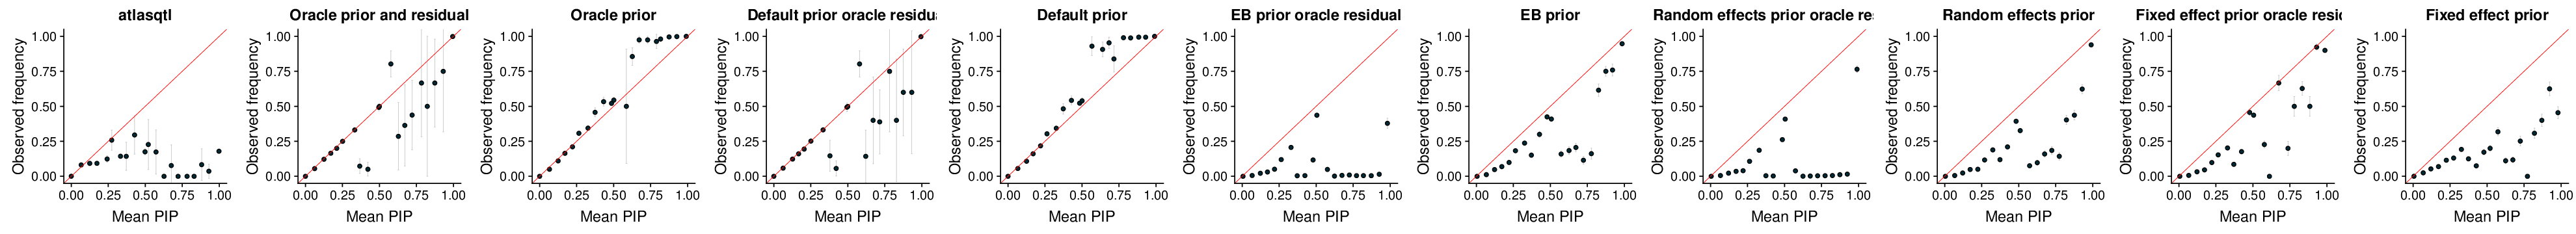

In [18]:
%preview PIP_comparison_0510.artificial_mixture.pip_evaluation.png

> PIP_comparison_0510.gtex_mixture.pip_evaluation.png (85.0 KiB):

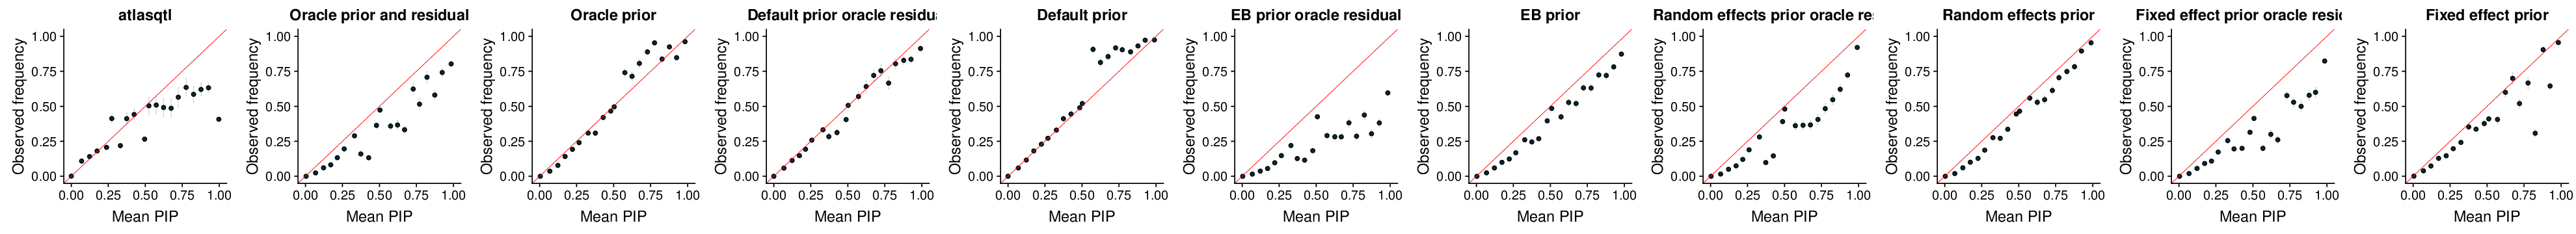

In [19]:
%preview PIP_comparison_0510.gtex_mixture.pip_evaluation.png

## Global PIP calibration for mvSuSiE

> PIP_comparison_0510.artificial_mixture.global.pip_evaluation.png (81.1 KiB):

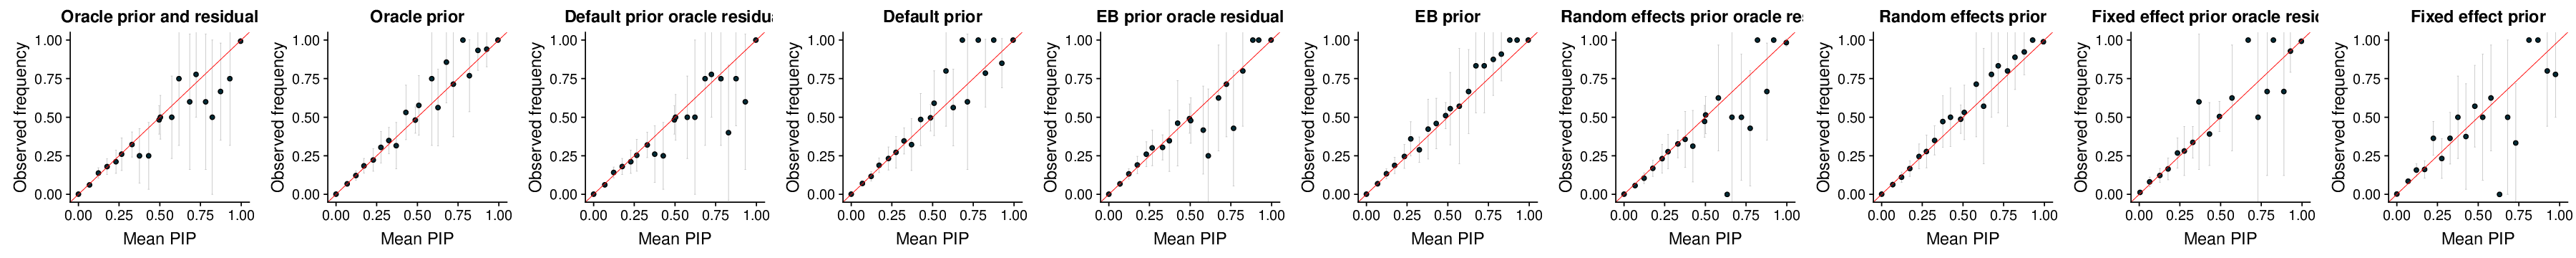

In [20]:
%preview PIP_comparison_0510.artificial_mixture.global.pip_evaluation.png

> PIP_comparison_0510.gtex_mixture.global.pip_evaluation.png (85.3 KiB):

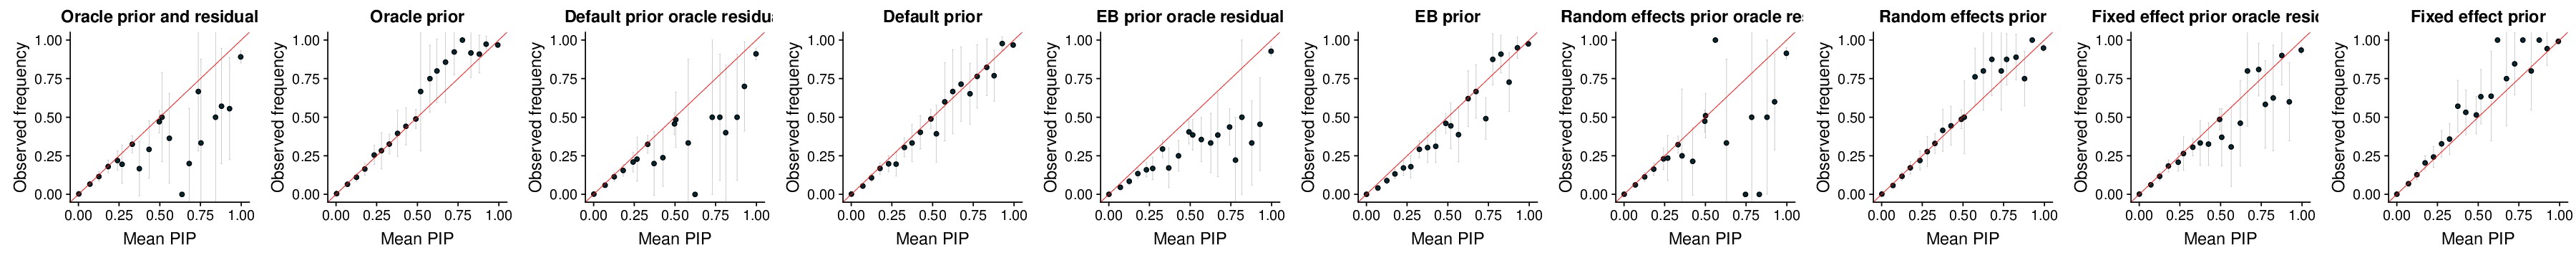

In [21]:
%preview PIP_comparison_0510.gtex_mixture.global.pip_evaluation.png

## ROC / PR curves

```
sos run 20200520_MNM_Benchmark.ipynb roc -s build
sos run 20200520_MNM_Benchmark.ipynb global_roc -s build
```

In [ ]:
# Data for ROC
[roc_3]
pip_cutoff = 0.05
output: f'{_input:nn}.roc.rds'
R: expand = '${ }', workdir = cwd
    roc_data = function(d1, cutoff = c(${pip_cutoff}, 0.999), connect_org = T) {
        grid = 500
        ttv = seq(1:grid)/grid
        ttv = ttv[which(ttv>=cutoff[1] & ttv<=cutoff[2])]
        rst1 = t(sapply(ttv, function(x) c(sum(d1[,2][d1[,1]>=x]), length(d1[,2][d1[,1]>=x]))))
        rst1 = cbind(rst1, sum(d1[,2]))
        rst1 = as.data.frame(rst1)
        colnames(rst1) = c('true_positive', 'total_positive', 'total_signal')
        rst2 = as.data.frame(cbind(rst1$true_positive / rst1$total_positive, rst1$true_positive / rst1$total_signal,  ttv))
        if (connect_org) {
            # make a stair to origin
            rst2 = rbind(rst2, c(max(0.995, rst2[nrow(rst2),1]), max(rst2[nrow(rst2),2]-0.01, 0), rst2[nrow(rst2),3]))
            rst2 = rbind(rst2, c(1, 0, 1))
        }
        colnames(rst2) = c('Precision', 'Recall', 'Threshold')
        return(list(counts = rst1, rates = rst2))
    }

    print("Computing ROC data ...")
    roc = list()
    dat = readRDS(${_input:r})
    for (method in names(dat)) {
      print(method)
      roc[[method]] = roc_data(dat[[method]])
    }
    saveRDS(roc, ${_output:r})

In [ ]:
# Plot for ROC
[roc_4]
depends: R_library('scam')
parameter: chunks = 0
parameter: smooth = 'FALSE'
parameter: opt = "lwd = 2, xlim = c(0,0.8), ylim = c(0,0.8)"
parameter: main = "FDR vs Power"
output: f'{_input:nn}.roc.pdf'
R: expand = '${ }'
    colors = c('#A60628', '#7A68A6', '#348ABD', '#467821', '#FF0000', '#188487', '#E2A233',
                  '#A9A9A9', '#000000', '#FF00FF', '#FFD700', '#ADFF2F', '#00FFFF')
    dat = readRDS(${_input:r})
    library(scam)
    create_chunks = function(item, n) {
      splitted = suppressWarnings(split(item, 1:n))
      return(c(splitted[[1]], splitted[[length(splitted)]][length(splitted[[length(splitted)]])]))
    }
    make_smooth = function(x,y,subset=${chunks}, smooth = ${smooth}) {
      if (smooth) {
          if (subset < length(x) && subset > 0) {
              x = create_chunks(x, subset)
              y = create_chunks(y, subset)
          }
          dat = data.frame(cbind(x,y))
          colnames(dat) = c('x','y')
          y=predict(scam(y ~ s(x, bs = "mpi"), data = dat))
      }
      return(list(x=x,y=y))
    }
    add_text = function(thresholds, x, y, threshold, color, delta = -0.06) {
        idx = which(thresholds == threshold)
        text(x[idx] - delta, y[idx], labels = threshold, col = color, cex=0.8)
        points(x[idx],y[idx])
    }
    rename = list('mnm_oracle+oracle' = 'Oracle prior and residual', 'mnm_oracle+flash' = 'Oracle prior', 'mnm_naive+oracle' = 'Default prior oracle residual', 
                  'mnm_naive+flash' = 'Default prior', 'mnm_ed+oracle' = 'EB prior oracle residual', 'mnm_ed+flash' = 'EB prior', 
                  'mnm_identity+oracle' = 'Random effects prior oracle residual', 'mnm_identity+flash' = 'Random effects prior',
                  'mnm_shared+oracle' = 'Fixed effect prior oracle residual', 'mnm_shared+flash' = 'Fixed effect prior', atlasqtl = 'atlasqtl')
    labels = vector()
    pdf(${_output:r}, width=10, height=10, pointsize=15)
    i = 1
    for (method in names(dat)) {
        yy = make_smooth(1 - dat[[method]]$rates$Precision, dat[[method]]$rates$Recall)
        if (i == 1) {
            plot(yy$x, yy$y, t="l", col=colors[i], ylab = "power", xlab ="FDR", main = "${main}", bty='l', ${opt})
        } else {
            lines(yy$x, yy$y, col=colors[i], ${opt})
        }
        #add_text(dat[[method]]$rates$Threshold, yy$x, yy$y, 0.9, colors[i])
        add_text(dat[[method]]$rates$Threshold, yy$x, yy$y, 0.95, colors[i])
        labels[i] = rename[[method]]
        i = i + 1
    }
    legend("bottomright", legend=labels, col=colors[1:i], lty=c(1,1,1), cex=0.8)
    dev.off()
[global_roc]
sos_run('global_pip:1+global_pip:2+roc:3+roc:4')

## PR curve for condition specific lfsr

> PIP_comparison_0510.artificial_mixture.roc.pdf (23.9 KiB):

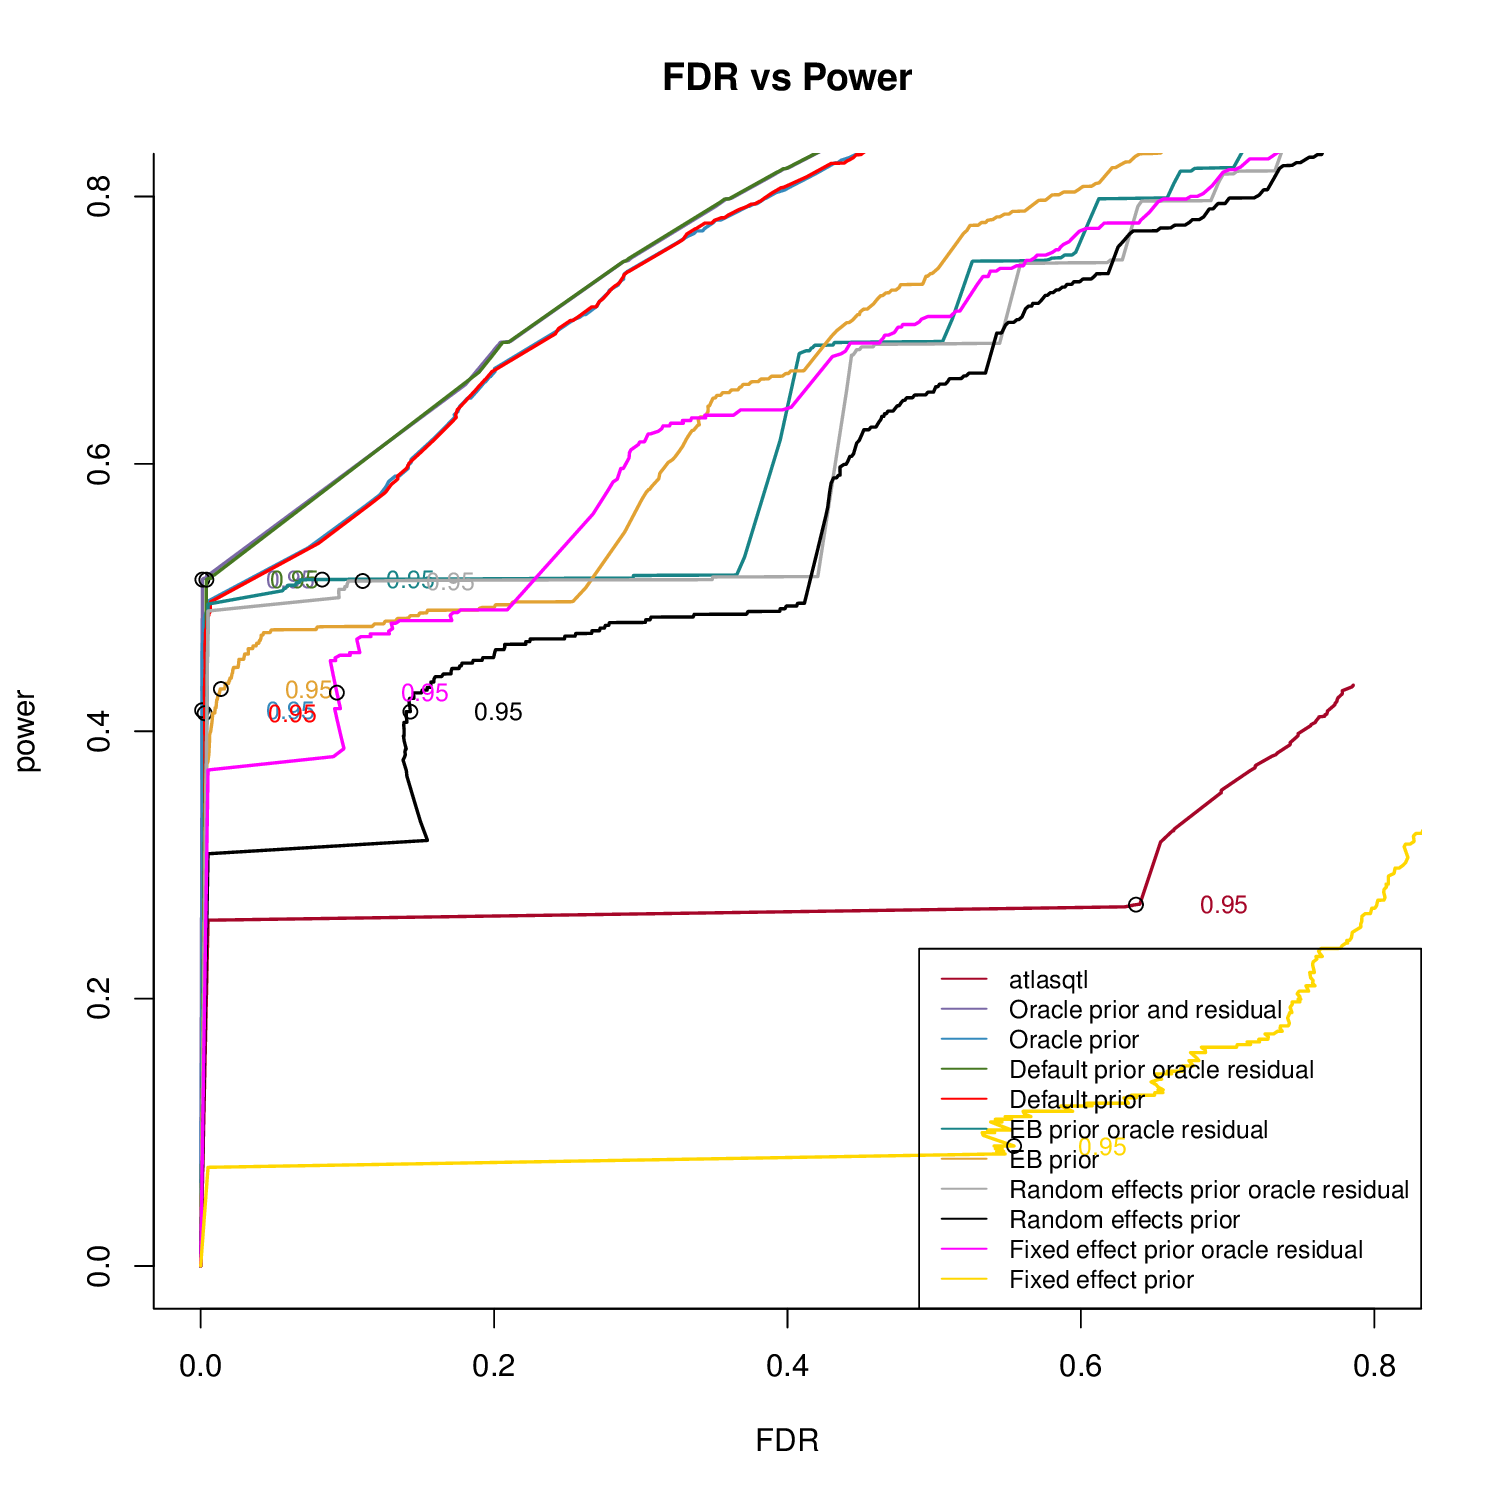

In [22]:
%preview PIP_comparison_0510.artificial_mixture.roc.pdf -s png

> PIP_comparison_0510.gtex_mixture.roc.pdf (33.5 KiB):

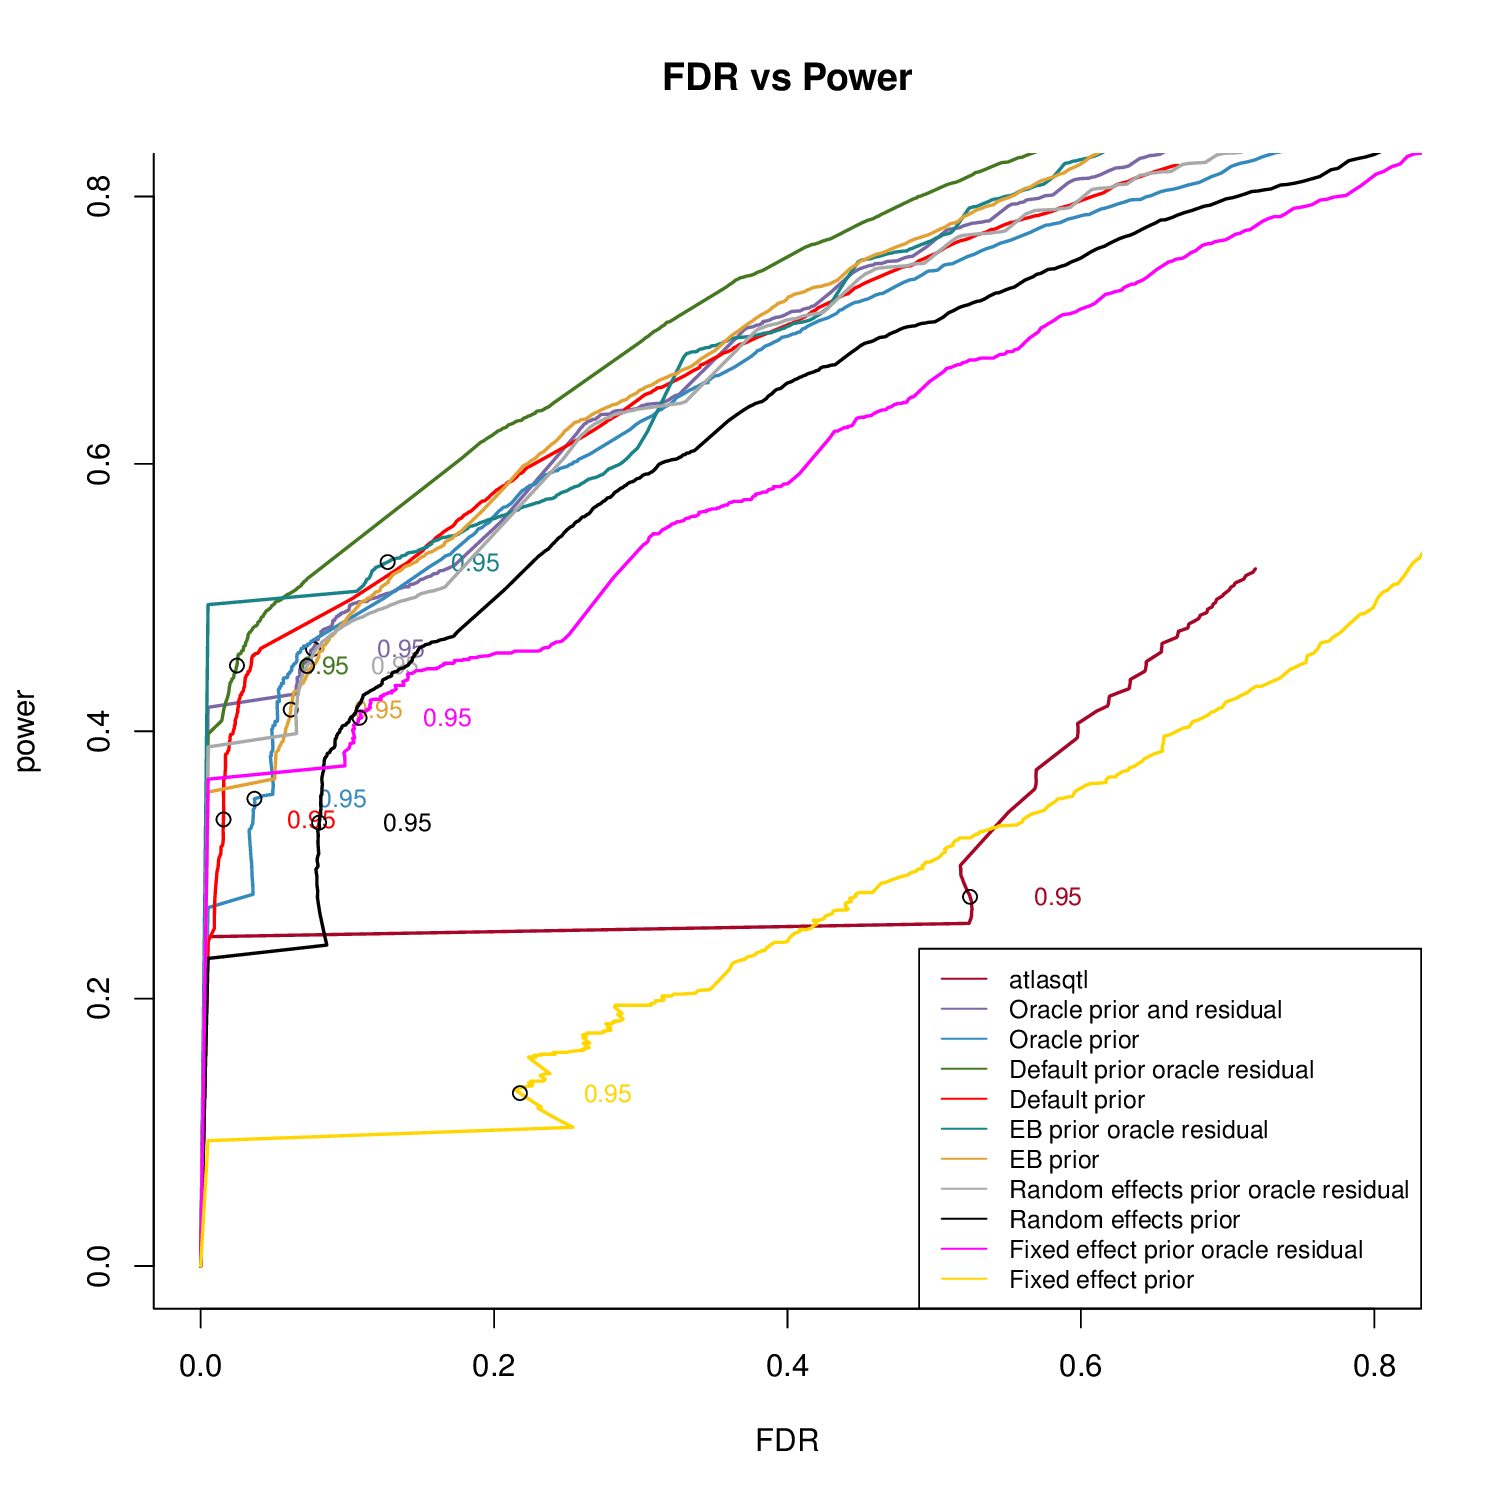

In [23]:
%preview PIP_comparison_0510.gtex_mixture.roc.pdf -s png

## PR curve for global PIP

> PIP_comparison_0510.artificial_mixture.global.roc.pdf (18.2 KiB):

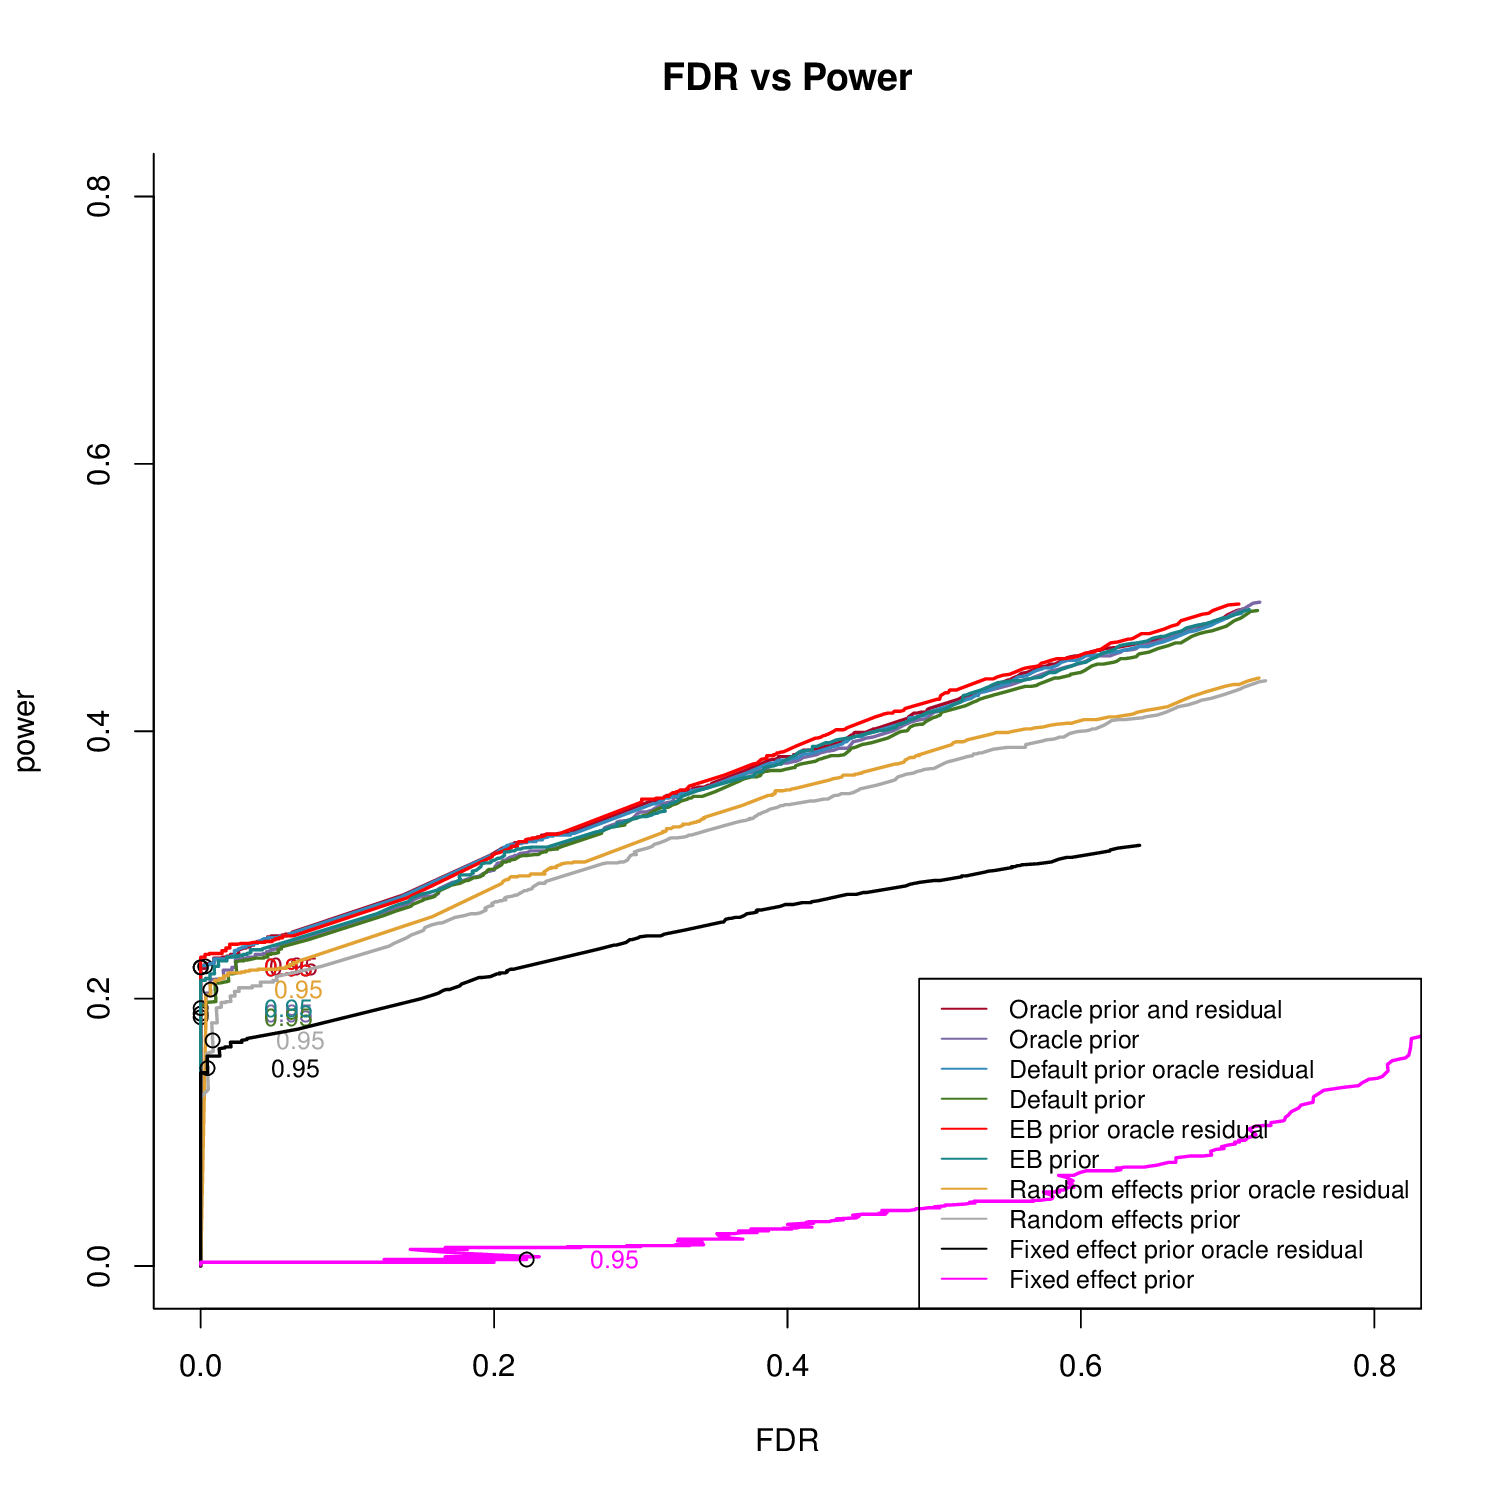

In [24]:
%preview PIP_comparison_0510.artificial_mixture.global.roc.pdf -s png

> PIP_comparison_0510.gtex_mixture.global.roc.pdf (21.0 KiB):

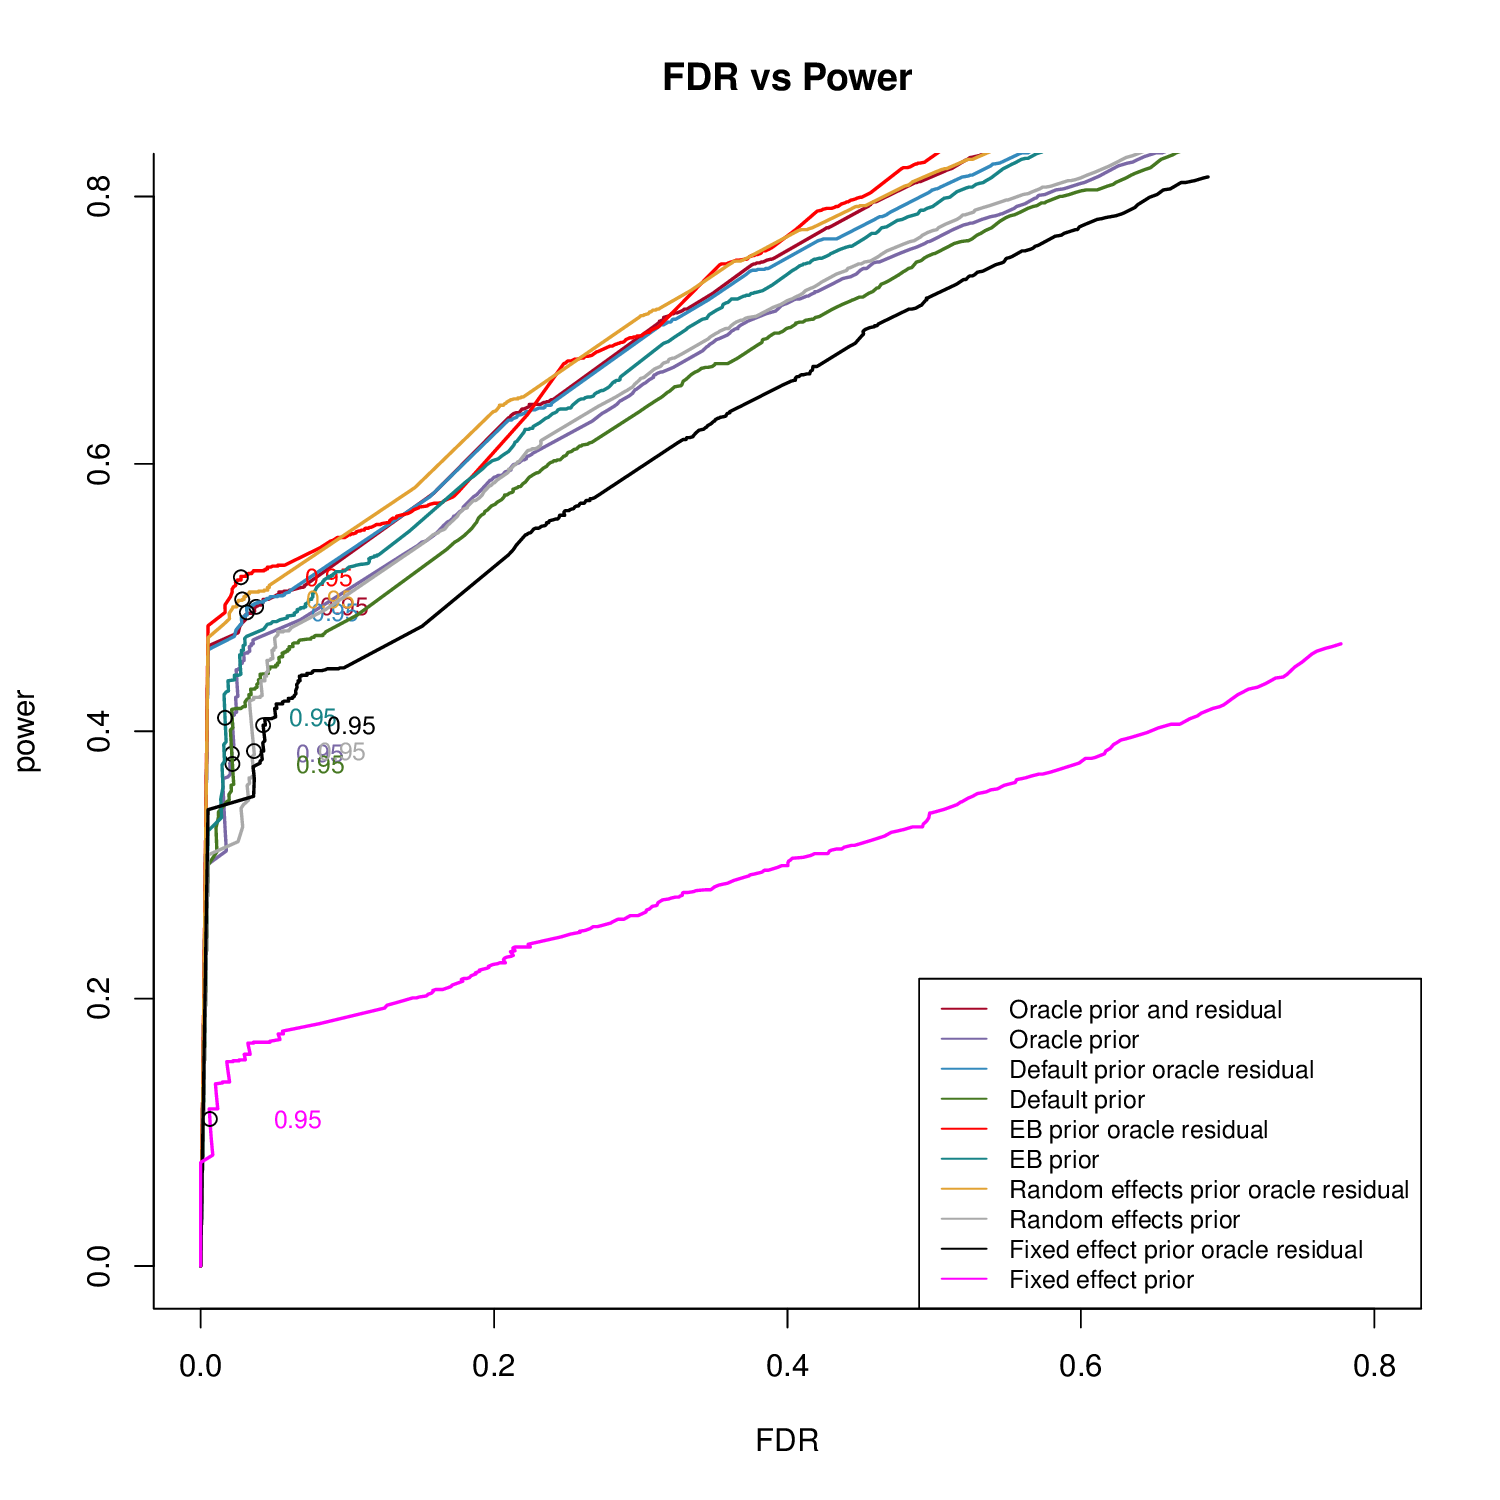

In [25]:
%preview PIP_comparison_0510.gtex_mixture.global.roc.pdf -s png